# E-Bike Survey Data Exploration & Pre-processing

*By [Danny Luo](https://dluo.me/)*

The following is a notebook that performs data EDA and trains ML models on the [City of Toronto E-Bike Survey Response Results](https://www1.toronto.ca/wps/portal/contentonly?vgnextoid=b3fc9ba6aa360410VgnVCM10000071d60f89RCRD&vgnextchannel=7807e03bb8d1e310VgnVCM10000071d60f89RCRD). An official desription follows: 

*'Between April 10 and May 8, 2013 the City of Toronto posted an online survey, which sought to gather demographic, travel and public opinion data to better understand e-bikes, and how City of Toronto policy should be directed to incorporate them into Toronto's Transportation mix.'*

I use Jupyter Notebook as the preferred method of showcasing my results due to its transparency and fantastic visualization capabilities. However, when moving to production-level, the functions and models below may be packaged into a python module and called at the user's convenience.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os, sys, gc
import glob
import datetime

color = sns.color_palette()

from IPython.display import display, HTML

%matplotlib inline

## Data Exploration & Preparation

In [2]:
#Reading the data

data_path = 'E-Bike_Survey_Responses.csv'
df_raw = pd.read_csv(data_path)

In [3]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 50)

df_raw.head(3)

,Timestamp,What age range do you fall in?,Sex,How would you describe your level of physical health?,What level of education have you reached?,What is your household income?,Which category best describes your employment?,What Toronto district is your primary address located in?,On average what distance do you travel most days of the week?,On average how long is your commute?,Which transportation option do you end up using most often?,Does your household have access to any of the following private motorized vehicles?,Do you support any of the following statements?,When you use Toronto's Multi-Use Trails do you mostly,Are you aware that the Multi-Use Paths have a speed limit of 20 km/h?,Have you witnessed a collision or conflict on a trail between,Do you think more should be done to manage trail users who do not respect the 20 km/h speed limit?,Currently any kind of e-bike may use a multi-use path if they are propelled by pedaling only and those propelled by motor power may be fined,When you use Toronto's bicycle lanes do you mostly,Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power may be fined,With regards to illegal use of bicycles and e-bikes on sidewalks should the City,Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City
0,2013-04-10 12:10,35 to 49,Male,Good,Post graduate,$100K+,Self Employed,Central Toronto York or East York,Under 2 km,15 minutes or less,scooter type e-bike,Yes - a scooter style e-bike,On scooter type e-bikes the pedals are unnecessary and should not be required Most scooter type ...,drive a motor propelled e-bike,No,pedestrians and/or runners a conflict relating to an in-line skater,No - the trails are fine as they are,The bylaw should be modified to allow any kind of e-bike including scooter type e-bikes use the ...,drive a scooter type e-bike propelled by an electric motor,The bylaw should be modified to allow e-bikes to drive in bicycle lanes using their motors and n...,be tolerant of bikes and e-bikes on the walkside if they go slow,Institute a speed limit for sidewalks
1,2013-04-10 12:30,18 to 34,Male,Excellent,University degree,$40K to $59K,Full Time,Central Toronto York or East York,10 - 20 km,30 - 44 minutes,scooter type e-bike,Yes - a scooter style e-bike,On scooter type e-bikes the pedals are unnecessary and should not be required Most e-bikes are a...,I very rarely use any of Toronto's Multi-Use Paths,No,I am not aware of any conflicts on the trails,No - the trails are fine as they are,No changes are necessary to the existing bylaw,drive a scooter type e-bike propelled by an electric motor,The bylaw should be modified to allow e-bikes to drive in bicycle lanes using their motors and n...,maintain the existing programs for signage education and enforcement increase signage increase e...,Do nothing
2,2013-04-10 12:33,50 to 64,Male,Good,University degree,$40K to $59K,Self Employed,Central Toronto York or East York,10 - 20 km,15 minutes or less,private motor vehicle (car truck SUV van motorcycle gas limited speed motorcycle or moped),Yes - a car SUV truck or van,Most scooter type e-bikes are wider than a bicycle Most scooter type e-bikes weigh more than an ...,cycle I very rarely use any of Toronto's Multi-Use Paths,No,I am not aware of any conflicts on the trails,Yes - more signage Yes - more enforcement (ticketing) Yes - more educational programs,No changes are necessary to the existing bylaw,ride a road bicycle or a fixie,No changes are necessary to the existing bylaw,increase signage increase enforcement increase education ticket,only wheelchairs at walking speed


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238 entries, 0 to 2237
Data columns (total 22 columns):
Timestamp                                                                                                                                        2238 non-null object
What age range do you fall in?                                                                                                                   2234 non-null object
Sex                                                                                                                                              2221 non-null object
How would you describe your level of physical health?                                                                                            2227 non-null object
What level of education have you reached?                                                                                                        2220 non-null object
What is your household income?                                 

In [25]:
#Missing values

df_raw.loc[df_raw.isnull().any(axis=1)].head()

,Timestamp,What age range do you fall in?,Sex,How would you describe your level of physical health?,What level of education have you reached?,What is your household income?,Which category best describes your employment?,What Toronto district is your primary address located in?,On average what distance do you travel most days of the week?,On average how long is your commute?,Which transportation option do you end up using most often?,Does your household have access to any of the following private motorized vehicles?,Do you support any of the following statements?,When you use Toronto's Multi-Use Trails do you mostly,Are you aware that the Multi-Use Paths have a speed limit of 20 km/h?,Have you witnessed a collision or conflict on a trail between,Do you think more should be done to manage trail users who do not respect the 20 km/h speed limit?,Currently any kind of e-bike may use a multi-use path if they are propelled by pedaling only and those propelled by motor power may be fined,When you use Toronto's bicycle lanes do you mostly,Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power may be fined,With regards to illegal use of bicycles and e-bikes on sidewalks should the City,Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City
23,2013-04-10 13:57,50 to 64,Male,Very good,Post graduate,NaN,Self Employed,Central Toronto York or East York,Under 2 km,15 minutes or less,bicycle,Yes - a car SUV truck or van,scooter style e-bikes are different than pedal assisted bicycle type e-bikes and should not be c...,cycle,No,a conflict between cyclists and pedestrians a conflict between two cyclists,Yes - more signage Yes - more enforcement (ticketing),Motorized vehicles should generally not be allowed on the trail but a special provision should b...,ride a commuter or cruiser style bicycle,No changes are necessary to the existing bylaw The bylaw should be modified to allow e-bikes to ...,increase signage increase enforcement,Update the definition of a personal mobility device so that they must travel at speeds close to ...
40,2013-04-10 16:18,35 to 49,Female,Very good,University degree,$100K+,Full Time,Central Toronto York or East York,5 - 10 km,16 - 29 minutes,bicycle,also motorcycle - not allowing more than one choice,scooter style e-bikes are different than pedal assisted bicycle type e-bikes and should not be c...,cycle,No,pedestrians and/or runners a conflict relating to a dog(s) a conflict relating to an in-line ska...,Yes - more signage Yes - more educational programs,Motorized vehicles should generally not be allowed on the trail but a special provision should b...,ride a commuter or cruiser style bicycle,Motorized vehicles should generally not be allowed in bicycle lanes but a special provision shou...,maintain the existing programs for signage education and enforcement,NaN
60,2013-04-10 18:24,35 to 49,Female,Excellent,University degree,NaN,Full Time,Central Toronto York or East York,Over 35 km,45 minutes - 1 hour,private motor vehicle (car truck SUV van motorcycle gas limited speed motorcycle or moped),Yes - a car SUV truck or van,E-bikes should require a license E-bikes should be required to have insurance,walk run skate cycle,No,I am not aware of any conflicts on the trails,Yes - more educational programs,No changes are necessary to the existing bylaw,ride a road bicycle or a fixie,No changes are necessary to the existing bylaw,increase enforcement,Update the definition of a personal mobility device so that they must travel at speeds close to ...
215,2013-04-12 10:08,35 to 49,Female,NaN,University degree,$100K+,Full Time,Scarborough,20 -35 km,30 - 44 minutes,transit,Yes - a car SUV truck or van,scooter style e-bikes are different than pedal assisted bicycle type e-bikes and should not be c...,cycle,No,a conflict between cyclists and pedestrians witnessed many 'almost' accidents,No - 

In [5]:
df_raw.describe()

,Timestamp,What age range do you fall in?,Sex,How would you describe your level of physical health?,What level of education have you reached?,What is your household income?,Which category best describes your employment?,What Toronto district is your primary address located in?,On average what distance do you travel most days of the week?,On average how long is your commute?,Which transportation option do you end up using most often?,Does your household have access to any of the following private motorized vehicles?,Do you support any of the following statements?,When you use Toronto's Multi-Use Trails do you mostly,Are you aware that the Multi-Use Paths have a speed limit of 20 km/h?,Have you witnessed a collision or conflict on a trail between,Do you think more should be done to manage trail users who do not respect the 20 km/h speed limit?,Currently any kind of e-bike may use a multi-use path if they are propelled by pedaling only and those propelled by motor power may be fined,When you use Toronto's bicycle lanes do you mostly,Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power may be fined,With regards to illegal use of bicycles and e-bikes on sidewalks should the City,Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City
count,2238,2234,2221,2227,2220,2178,2223,2237,2237,2237,2238,2238,2238,2238,2238,2238,2237,2238,2238,2238,2238,2232
unique,1722,5,12,12,24,6,33,68,5,6,33,123,534,89,2,221,134,25,69,258,224,81
top,2013-04-12 10:23,35 to 49,Male,Very good,University degree,$100K+,Full Time,Central Toronto York or East York,5 - 10 km,16 - 29 minutes,bicycle,Yes - a car SUV truck or van,scooter style e-bikes are different than pedal assisted bicycle type e-bikes and should not be c...,cycle,No,I am not aware of any conflicts on the trails,No - the trails are fine as they are,No changes are necessary to the existing bylaw,ride a commuter or cruiser style bicycle,No changes are necessary to the existing bylaw,maintain the existing programs for signage education and enforcement,Update the definition of a personal mobility device so that they must travel at speeds close to ...
freq,7,863,1554,891,895,831,1405,1634,847,782,777,1146,84,738,1131,847,646,811,705,664,493,1379


### Note

There are a lot of complicated text responses, which will provide some difficulty in incorporating that data with a model. From the `unique` field in `describe`, we see that the low unique counts indicate that most of the responses are fixed and not freely typed. The ones that have a high `unique` count are the ones that ask the responder to indicate *'any of the following'* responses.

In order to input these variables into a ML model, we must encode the columns into a numerical label.

First, we must determine which columns are **single-answer** and which are **multi-answer**. In addition to looking at the question title, we can take a look at the unique responses for each column. 

(This may be expediated if we had access to the original survey)

In [6]:
for c in df_raw.columns:
    print("\n---- %s ---\n" % c)
    display(df_raw[c].value_counts())


---- Timestamp ---



2013-04-12 10:23    7
2013-04-12 11:19    7
2013-04-12 11:56    6
2013-04-12 10:44    6
2013-04-12 9:38     6
2013-04-12 11:36    6
2013-04-12 11:29    6
2013-04-12 10:54    5
2013-04-12 9:55     5
2013-04-12 9:31     5
2013-04-12 10:50    5
2013-04-12 12:39    5
2013-04-12 10:06    5
2013-04-12 10:08    5
2013-04-12 11:42    5
2013-04-12 11:58    5
2013-04-12 10:37    5
2013-04-12 9:43     5
2013-04-12 10:11    5
2013-04-12 9:51     5
2013-04-12 11:06    5
2013-04-12 10:46    5
2013-04-12 10:18    4
2013-04-12 10:34    4
2013-04-12 13:06    4
                   ..
2013-04-10 19:13    1
2013-04-13 13:13    1
2013-04-10 12:51    1
2013-04-18 8:14     1
2013-04-10 13:21    1
2013-04-30 15:39    1
2013-04-15 12:38    1
2013-04-10 18:09    1
2013-05-03 17:42    1
2013-04-10 14:13    1
2013-04-15 10:30    1
2013-04-10 23:26    1
2013-04-15 11:54    1
2013-04-19 10:55    1
2013-04-15 14:47    1
2013-05-05 17:33    1
2013-04-13 23:36    1
2013-05-06 22:28    1
2013-05-07 12:40    1
2013-04-14


---- What age range do you fall in? ---



35 to 49            863
18 to 34            789
50 to 64            463
65 years or more    111
17 or younger         8
Name: What age range do you fall in?, dtype: int64


---- Sex ---



Male                       1554
Female                      657
Genderqueer                   1
they                          1
fifth                         1
please                        1
Irrelevant                    1
prefer not to disclose        1
Transgender                   1
trans                         1
Trans Female                  1
unspecified                   1
Name: Sex, dtype: int64


---- How would you describe your level of physical health? ---



Very good                                    891
Good                                         667
Excellent                                    411
Fairly good                                  210
Poor                                          41
healing fractured heel                         1
healthy but with arthritis mobilty issues      1
In poor shape but active & improving           1
Back Injury                                    1
Obese diabetic but trying to be healthy        1
need knee replacement                          1
Disabled                                       1
Name: How would you describe your level of physical health?, dtype: int64


---- What level of education have you reached? ---



University degree                                    895
Post graduate                                        591
College or trade school diploma                      521
High school diploma                                  192
Some university                                        2
Professional degree                                    1
4 years university no degree                           1
Professional Certifications                            1
Some University                                        1
PhD                                                    1
still in school                                        1
some university                                        1
M D                                                    1
Grade 8                                                1
college degree (not university and not a diploma)      1
Grade 9                                                1
Law School                                             1
in HS                          


---- What is your household income? ---



$100K+          831
$60K to $79K    372
$80K to $99K    335
$40K to $59K    298
$20K to $39K    235
Under $20K      107
Name: What is your household income?, dtype: int64


---- Which category best describes your employment? ---



Full Time                                                                                                                            1405
Self Employed                                                                                                                         361
Retired                                                                                                                               136
Part Time                                                                                                                             121
Student                                                                                                                               118
Unemployed                                                                                                                             37
Home Maker                                                                                                                             17
disabled                          


---- What Toronto district is your primary address located in? ---



Central Toronto York or East York                 1634
Etobicoke                                          236
North York                                         129
Scarborough                                        120
Mississauga                                         24
Brampton                                             9
Pickering                                            4
Waterloo                                             4
Guelph                                               3
Richmond Hill                                        3
oshawa                                               3
Oakville                                             3
markham                                              2
GTA                                                  2
ottawa                                               2
mississauga                                          2
Hamilton                                             2
Markham                                              2
Bulington 


---- On average what distance do you travel most days of the week? ---



5 - 10 km     847
10 - 20 km    653
Over 35 km    293
20 -35 km     248
Under 2 km    196
Name: On average what distance do you travel most days of the week?, dtype: int64


---- On average how long is your commute? ---



16 - 29 minutes         782
30 - 44 minutes         565
15 minutes or less      375
45 minutes - 1 hour     246
I do not commute        167
over 1 hour each way    102
Name: On average how long is your commute?, dtype: int64


---- Which transportation option do you end up using most often? ---



bicycle                                                                                       777
private motor vehicle (car truck SUV van motorcycle gas limited speed motorcycle or moped)    631
transit                                                                                       364
walking                                                                                       247
scooter type e-bike                                                                           105
pedal assist type e-bike                                                                       86
personal mobility device (electric wheelchair)                                                  2
skateboard/longboard                                                                            1
CONDO SHUTTLE BUS                                                                               1
depends on the season three seasons bike one transit                                            1
private motor vehicl


---- Does your household have access to any of the following private motorized vehicles? ---



Yes - a car SUV truck or van                                                                                                          1146
No - I do not have access to a private motorized vehicle                                                                               522
Yes a motorcycle                                                                                                                       162
Yes - a pedal assist type e-bike                                                                                                        99
Yes - a scooter style e-bike                                                                                                            85
Yes - a car SUV truck or van Yes a motorcycle                                                                                           25
Yes - a car SUV truck or van Yes - a scooter style e-bike                                                                               22
Yes - a car SUV truck or va


---- Do you support any of the following statements? ---



scooter style e-bikes are different than pedal assisted bicycle type e-bikes and should not be considered as one vehicle category Most scooter type e-bikes are wider than a bicycle Most scooter type e-bikes weigh more than an average bicycle Most e-bikes are able to travel further distances than an average cyclist of average fitness  Most e-bikes are able to sustain higher average speeds than an average cyclist of average fitness Most e-bikes are able to accelerate more quickly than an average cyclist of average fitness E-bikes should require a license E-bikes should be required to have insurance                                                                                                                                                                                                      84
Most scooter type e-bikes are wider than a bicycle Most scooter type e-bikes weigh more than an average bicycle Most e-bikes are able to travel further distances than an average cyclist of average


---- When you use Toronto's Multi-Use Trails do you mostly ---



cycle                                                                                                                                                                         738
walk cycle                                                                                                                                                                    282
walk                                                                                                                                                                          267
I very rarely use any of Toronto's Multi-Use Paths                                                                                                                            196
walk run cycle                                                                                                                                                                 93
pedal a pedal assist type e-bike                                                                              


---- Are you aware that the Multi-Use Paths have a speed limit of 20 km/h? ---



No     1131
Yes    1107
Name: Are you aware that the Multi-Use Paths have a speed limit of 20 km/h?, dtype: int64


---- Have you witnessed a collision or conflict on a trail between ---



I am not aware of any conflicts on the trails                                                                                                                                                                                                                                                              847
a conflict between cyclists and pedestrians                                                                                                                                                                                                                                                                138
a conflict relating to a dog(s)                                                                                                                                                                                                                                                                             80
a conflict between an e-biker and a pedestrian a conflict between e-biker and a cyclist    


---- Do you think more should be done to manage trail users who do not respect the 20 km/h speed limit? ---



No - the trails are fine as they are                                                                                                                                                            646
Yes - more signage Yes - more enforcement (ticketing) Yes - more educational programs                                                                                                           355
Yes - more enforcement (ticketing)                                                                                                                                                              276
Yes - more signage                                                                                                                                                                              260
Yes - more signage Yes - more educational programs                                                                                                                                              188
Yes - more signage Y


---- Currently any kind of e-bike may use a multi-use path if they are propelled by pedaling only and those propelled by motor power may be fined  ---



No changes are necessary to the existing bylaw                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            811
Motorized vehicles should generally not be allowed on the trail but a special provision should be made for e-bike users who are medically unable to propel a conventional bicycle using muscular power alone                                                                                                                                                                                                                                                              


---- When you use Toronto's bicycle lanes do you mostly ---



ride a commuter or cruiser style bicycle                                                                                                                                                            705
ride a road bicycle or a fixie                                                                                                                                                                      574
ride a mountain downhill or BMX bicycle                                                                                                                                                             347
I do not use bicycle lanes                                                                                                                                                                          288
pedal a pedal assist type e-bike                                                                                                                                                                    117



---- Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power may be fined  ---



No changes are necessary to the existing bylaw                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            664
Motorized vehicles should generally not be allowed in bicycle lanes but a special provision should be made for e-bike users who are medically unable to propel a conventional bicycle using muscular power alone                                                                                                                                                                                                          


---- With regards to illegal use of bicycles and e-bikes on sidewalks should the City  ---



maintain the existing programs for signage education and enforcement                                                                                                                                                                                                                493
increase enforcement                                                                                                                                                                                                                                                                348
increase signage increase enforcement increase education                                                                                                                                                                                                                            347
increase enforcement increase education                                                                                                                         


---- Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City ---



Update the definition of a personal mobility device so that they must travel at speeds close to walking speed                                                                                                                                                                                                                                                                             1379
Institute a speed limit for sidewalks                                                                                                                                                                                                                                                                                                                                                      374
Do nothing                                                                                                                                                                                                                                

### Note

* In many columns, most people answered according to the **given, fixed responses**, with a minority answering with their own typed responses (likely under an "Other: Please Specify" option).
* To include all these uniquely typed responses would overload our model. We seek to eliminate them. First we will see how many responses we omit responses with < 3 occurences.

Note that there are 2238 rows in total.


In [7]:
k = 5 #cut off number

for c in df_raw.columns:
    print("\n---- %s ---\n" % c)
    vc = df_raw[c].value_counts()
    print('After omitting responses with < %s occurences' %k)
    print('There are %s / 2238 responses' %vc[vc >= k].sum())
    print('Fraction kept: %0.4f' %(vc[vc >= k].sum()/2238.))
    print('Remaining responses %(rem)s out of %(total)s' %{'rem': len(vc[vc >= k]), 'total': len(vc)})


---- Timestamp ---

After omitting responses with < 5 occurences
There are 119 / 2238 responses
Fraction kept: 0.0532
Remaining responses 22 out of 1722

---- What age range do you fall in? ---

After omitting responses with < 5 occurences
There are 2234 / 2238 responses
Fraction kept: 0.9982
Remaining responses 5 out of 5

---- Sex ---

After omitting responses with < 5 occurences
There are 2211 / 2238 responses
Fraction kept: 0.9879
Remaining responses 2 out of 12

---- How would you describe your level of physical health? ---

After omitting responses with < 5 occurences
There are 2220 / 2238 responses
Fraction kept: 0.9920
Remaining responses 5 out of 12

---- What level of education have you reached? ---

After omitting responses with < 5 occurences
There are 2199 / 2238 responses
Fraction kept: 0.9826
Remaining responses 4 out of 24

---- What is your household income? ---

After omitting responses with < 5 occurences
There are 2178 / 2238 responses
Fraction kept: 0.9732
Remaini

### Visualization

For each column, I plot the frequency of their responses to further understand which columns vary largely in their responses. 


---- Timestamp ---



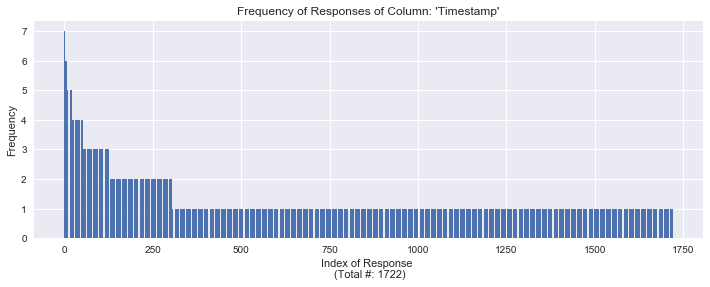


---- What age range do you fall in? ---



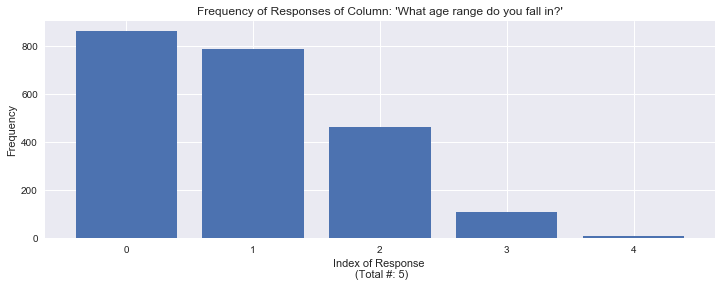


---- Sex ---



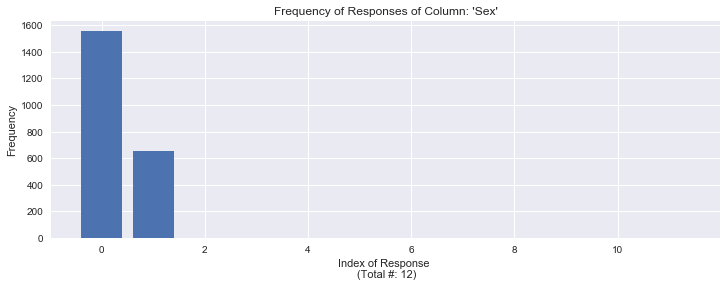


---- How would you describe your level of physical health? ---



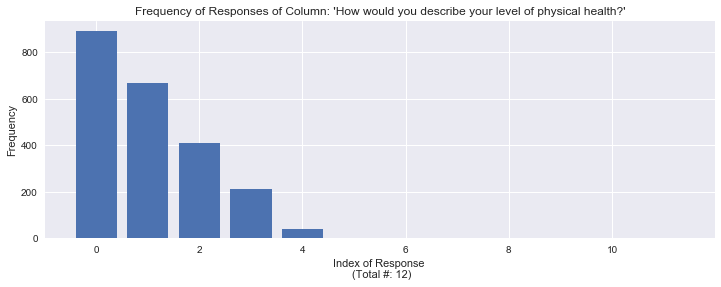


---- What level of education have you reached? ---



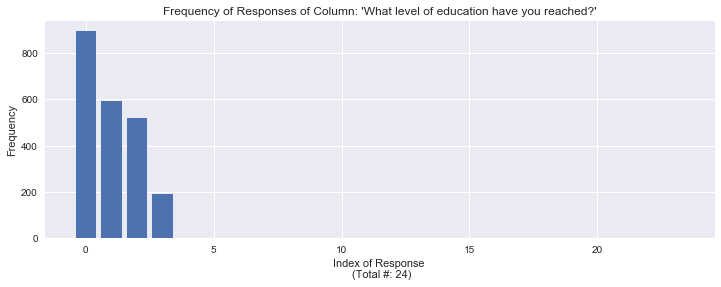


---- What is your household income? ---



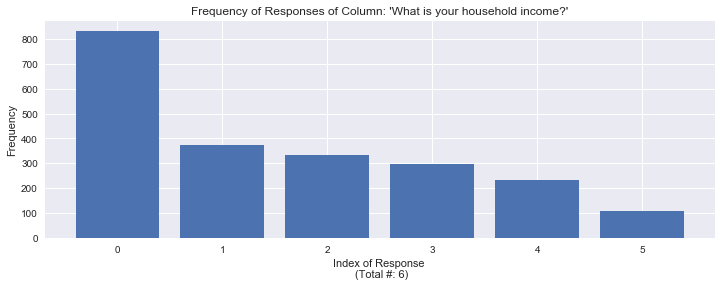


---- Which category best describes your employment? ---



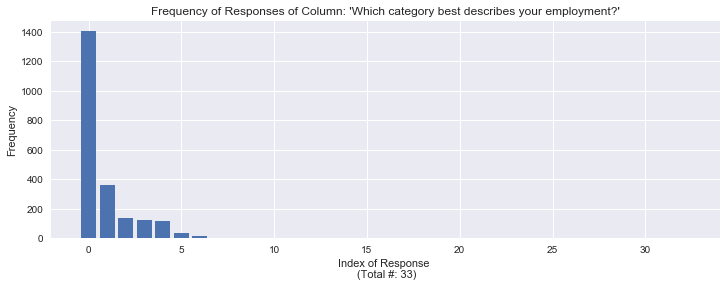


---- What Toronto district is your primary address located in? ---



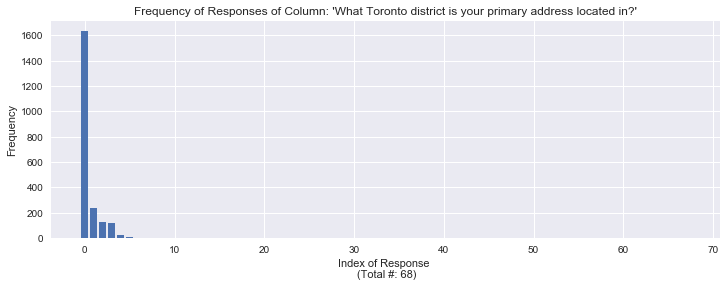


---- On average what distance do you travel most days of the week? ---



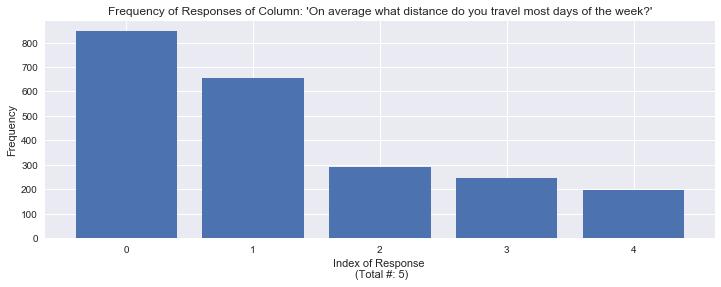


---- On average how long is your commute? ---



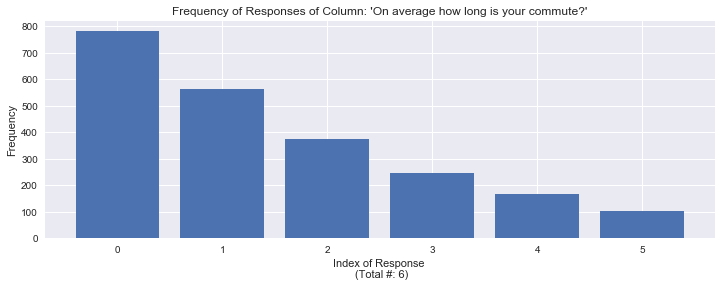


---- Which transportation option do you end up using most often? ---



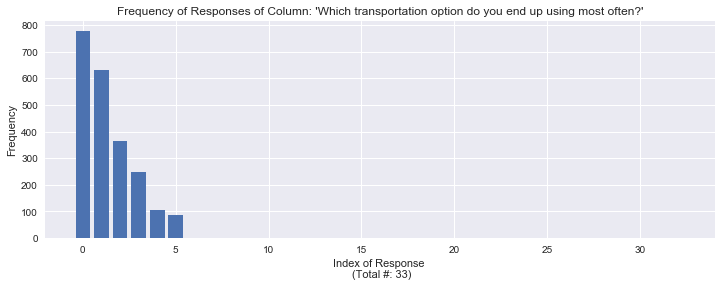


---- Does your household have access to any of the following private motorized vehicles? ---



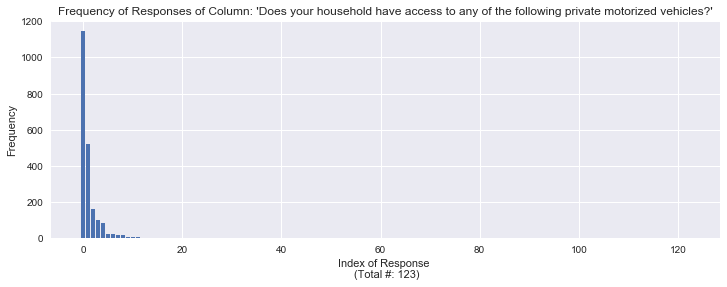


---- Do you support any of the following statements? ---



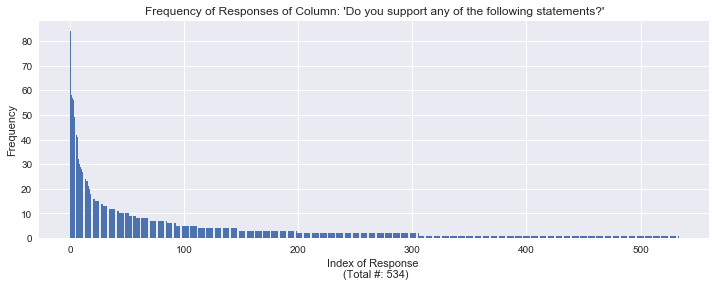


---- When you use Toronto's Multi-Use Trails do you mostly ---



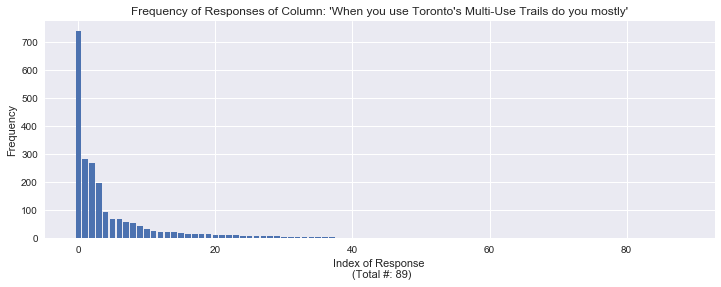


---- Are you aware that the Multi-Use Paths have a speed limit of 20 km/h? ---



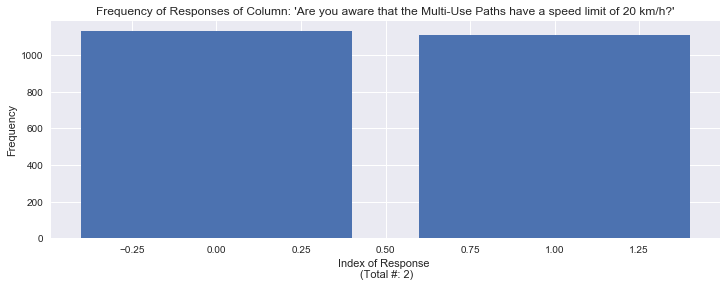


---- Have you witnessed a collision or conflict on a trail between ---



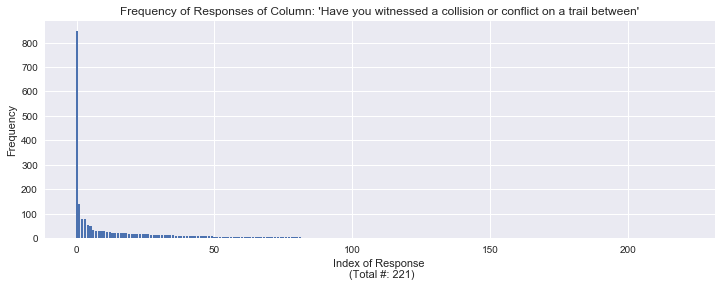


---- Do you think more should be done to manage trail users who do not respect the 20 km/h speed limit? ---



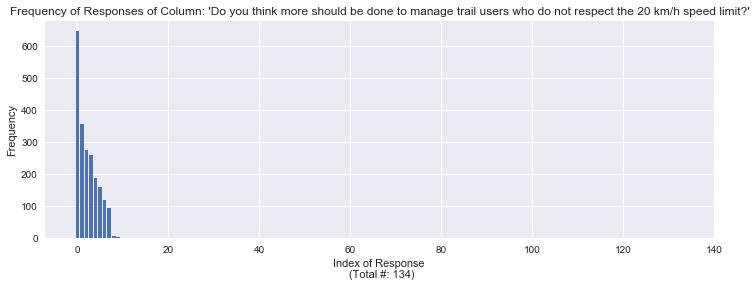


---- Currently any kind of e-bike may use a multi-use path if they are propelled by pedaling only and those propelled by motor power may be fined  ---



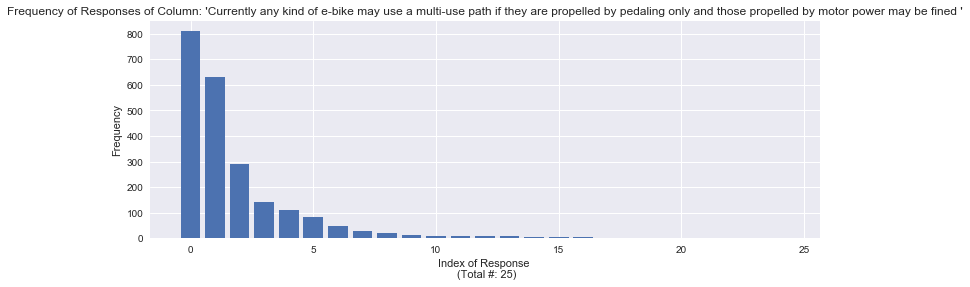


---- When you use Toronto's bicycle lanes do you mostly ---



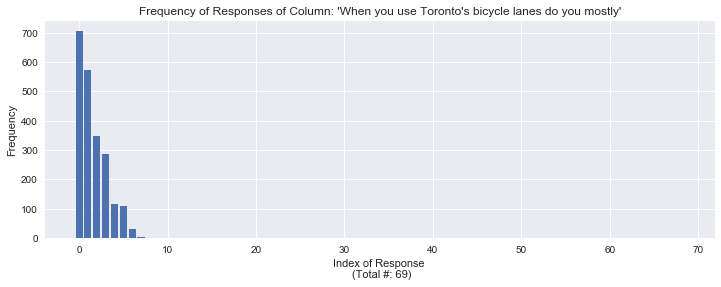


---- Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power may be fined  ---



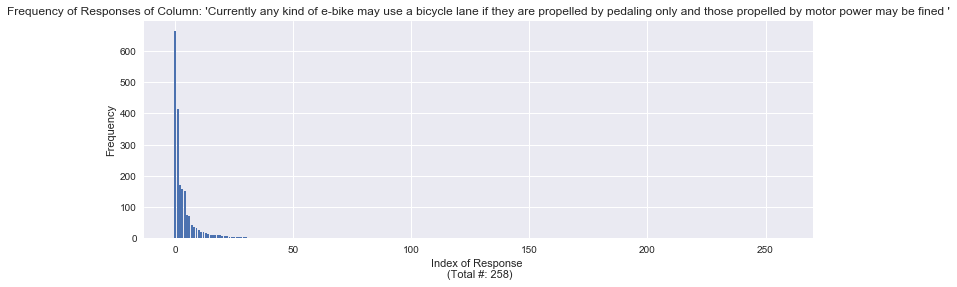


---- With regards to illegal use of bicycles and e-bikes on sidewalks should the City  ---



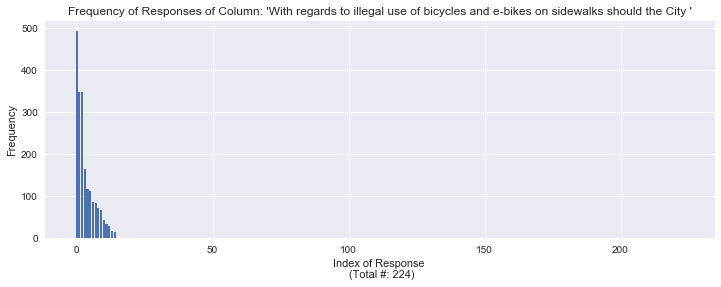


---- Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City ---



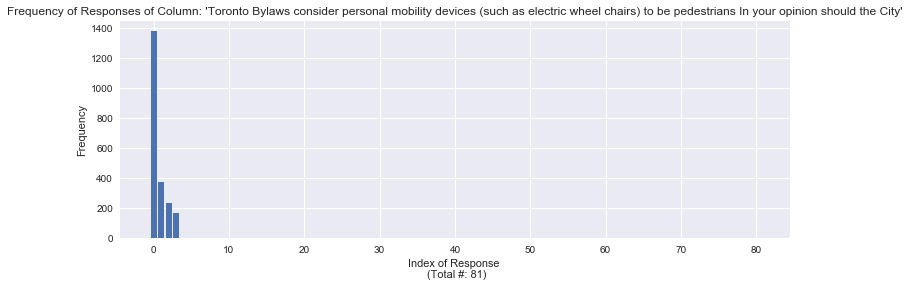

In [8]:
for c in df_raw.columns:
    print("\n---- %s ---\n" % c)
    vc = df_raw[c].value_counts()
    fig = plt.figure(figsize=(12, 4))
    plt.title("Frequency of Responses of Column: '%s'" % c)
    plt.ylabel('Frequency')
    plt.xlabel('Index of Response \n (Total #: %s)' % len(vc))
    plt.bar(np.arange(len(vc)), vc)
    plt.show()

### What Columns to Use?

**To Omit:**

* **Does your household have access to any of the following private motorized vehicles?** Label.
* **Do you support any of the following statements?** This multi-answer question has highly varying answers. Observing the frequency graph for this column, we see that responses with frequency < 10 constitute a substantial tail of the graph. Cutting of at frequency < 5 elimnates a hefty 34% of the responses. It is possible to break each of the multi-answer responses down into a list of single-answer responses, which is an option to be explored given more time.

**To Worry:**

* **Have you witnessed a collision or conflict on a trail between** Though removing < 5 occurences only eliminated 10% of the responses, there are still a lot of categories left over: 69 / 221. Hopefully, our model can ignore this column if is there is too much noise.
* **When you use Toronto's Multi-Use Trails do you mostly** 32 / 89 columns remaining.
* **Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power may be fined** 24 / 258 columns remaining.



The rest of the columns, with the exception of **Timestamp**, we will classify responses with < 5 frequencies as *'Other'*, as they typically indicate a uniquely-typed answer that is difficult for models to interpret. 

As stated before, for simplicity and time, we will not interpret multi-answer responses as a list of single-answer responses, but as different categories entirely.


In [9]:
omit_columns = ['Does your household have access to any of the following private motorized vehicles?', 'Do you support any of the following statements?']           
worry_columns = ['Have you witnessed a collision or conflict on a trail between', "When you use Toronto's Multi-Use Trails do you mostly",
                 'Currently any kind of e-bike may use a bicycle lane if they are propelled by pedaling only and those propelled by motor power may be fined '] 

In [10]:
# Predictors
df_pred = df_raw.drop(omit_columns, axis=1)


In [11]:
# Cut off at < 5 responses
k = 5 #cut off number

cols = list(df_pred.columns)
cols.remove('Timestamp')

for c in cols: #Omit timestamp
    print("\n---- %s ---\n" % c)
    vc = df_pred[c].value_counts()
    other_responses = vc[vc<k].index
    print("How many responses turned to 'Other': %s / 2238" % df_pred[c].isin(other_responses).sum())
    df_pred[c].loc[df_pred[c].isin(other_responses)] = 'Other'
    


---- What age range do you fall in? ---

How many responses turned to 'Other': 0 / 2238

---- Sex ---

How many responses turned to 'Other': 10 / 2238

---- How would you describe your level of physical health? ---

How many responses turned to 'Other': 7 / 2238

---- What level of education have you reached? ---

How many responses turned to 'Other': 21 / 2238

---- What is your household income? ---

How many responses turned to 'Other': 0 / 2238

---- Which category best describes your employment? ---

How many responses turned to 'Other': 28 / 2238

---- What Toronto district is your primary address located in? ---

How many responses turned to 'Other': 85 / 2238

---- On average what distance do you travel most days of the week? ---

How many responses turned to 'Other': 0 / 2238

---- On average how long is your commute? ---

How many responses turned to 'Other': 0 / 2238

---- Which transportation option do you end up using most often? ---

How many responses turned to 'Other':

### One-Hot Encoding

We perform one-hot encoding on the features, except **Timestamp** and **What age range do you fall in?**. Due to the natural ordering of the age range, it makes sense to label the responses in ascending order of age. Since there are not a lot of age ranges, it can be done manually.

In [12]:
df_pred['What age range do you fall in?'].unique()

array(['35 to 49', '18 to 34', '50 to 64', '17 or younger',
       '65 years or more', nan], dtype=object)

In [13]:
OHE_cols = list(df_pred.columns)
OHE_cols.remove('Timestamp')
OHE_cols.remove('What age range do you fall in?')

#OHE
df_pred_dummies = pd.get_dummies(df_pred, columns=OHE_cols)

#Age Range Labelling
age_range = {'17 or younger': 1, '18 to 34': 2, '35 to 49': 3, '50 to 64': 4, '65 years or more': 5}
df_pred_dummies.replace({'What age range do you fall in?': age_range}, inplace=True)

In [14]:
df_pred_dummies.head(2)

,Timestamp,What age range do you fall in?,Sex_Female,Sex_Male,Sex_Other,How would you describe your level of physical health?_Excellent,How would you describe your level of physical health?_Fairly good,How would you describe your level of physical health?_Good,How would you describe your level of physical health?_Other,How would you describe your level of physical health?_Poor,How would you describe your level of physical health?_Very good,What level of education have you reached?_College or trade school diploma,What level of education have you reached?_High school diploma,What level of education have you reached?_Other,What level of education have you reached?_Post graduate,...,With regards to illegal use of bicycles and e-bikes on sidewalks should the City _increase signage increase enforcement,With regards to illegal use of bicycles and e-bikes on sidewalks should the City _increase signage increase enforcement increase education,With regards to illegal use of bicycles and e-bikes on sidewalks should the City _maintain the existing programs for signage education and enforcement,With regards to illegal use of bicycles and e-bikes on sidewalks should the City _maintain the existing programs for signage education and enforcement increase education,With regards to illegal use of bicycles and e-bikes on sidewalks should the City _maintain the existing programs for signage education and enforcement increase enforcement,With regards to illegal use of bicycles and e-bikes on sidewalks should the City _maintain the existing programs for signage education and enforcement increase enforcement increase education,With regards to illegal use of bicycles and e-bikes on sidewalks should the City _maintain the existing programs for signage education and enforcement increase signage,With regards to illegal use of bicycles and e-bikes on sidewalks should the City _maintain the existing programs for signage education and enforcement increase signage increase education,With regards to illegal use of bicycles and e-bikes on sidewalks should the City _maintain the existing programs for signage education and enforcement increase signage increase enforcement,With regards to illegal use of bicycles and e-bikes on sidewalks should the City _maintain the existing programs for signage education and enforcement increase signage increase enforcement increase education,Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City_Do nothing,Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City_Don't Know / Rather Not Answer,Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City_Institute a speed limit for sidewalks,Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City_Other,Toronto Bylaws consider personal mobility devices (such as electric wheel chairs) to be pedestrians In your opinion should the City_Update the definition of a personal mobility device so that they must travel at speeds close to walking speed
0,2013-04-10 12:10,3.0,0,1,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2013-04-10 12:30,2.0,0,1,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


### Formatting the Label

The label column 'Does your household have access to any of the following private motorized vehicles?' also needs to be formatted. We take extra caution here because as the label column, it indicates to us the performance of the model. If the answers are wrong, then the model will learn incorrectly.

In [15]:
#Brief Overview
k = 2

pred_column = 'Does your household have access to any of the following private motorized vehicles?'
df_label = df_raw[pred_column].copy() #don't want to modify original raw file
vc = df_label.value_counts()

print('After omitting responses with < %s occurences' %k)
print('There are %s / 2238 responses' %vc[vc >= k].sum())
print('Fraction kept: %0.4f' %(vc[vc >= k].sum()/2238.))
print('Remaining responses %(rem)s out of %(total)s' %{'rem': len(vc[vc >= k]), 'total': len(vc)})

After omitting responses with < 2 occurences
There are 2137 / 2238 responses
Fraction kept: 0.9549
Remaining responses 22 out of 123


In [16]:
display(vc)

Yes - a car SUV truck or van                                                                                                          1146
No - I do not have access to a private motorized vehicle                                                                               522
Yes a motorcycle                                                                                                                       162
Yes - a pedal assist type e-bike                                                                                                        99
Yes - a scooter style e-bike                                                                                                            85
Yes - a car SUV truck or van Yes a motorcycle                                                                                           25
Yes - a car SUV truck or van Yes - a scooter style e-bike                                                                               22
Yes - a car SUV truck or va

### Note

It seems from above that nearly all who do not have access to a private motorized vehicle answered: *'No - I do not have access to a private motorized vehicle'*. Nearly all who didn't, indicated that they owned a vehicle of some sort. This assumption is not too bad, as there will not be many false classifications (observe the results above). 

We will set those who answered *'No - I do not have access to a private motorized vehicle'* to 0, all others to 1 to indicate otherwise (typically *'Yes, I have a access to a private motorized vehicle'*).

In [17]:
df_label.head(10)

0                                Yes - a scooter style e-bike
1                                Yes - a scooter style e-bike
2                                Yes - a car SUV truck or van
3                                Yes - a car SUV truck or van
4                                Yes - a car SUV truck or van
5    No - I do not have access to a private motorized vehicle
6                                            Yes a motorcycle
7                                Yes - a car SUV truck or van
8                                Yes - a car SUV truck or van
9                                Yes - a car SUV truck or van
Name: Does your household have access to any of the following private motorized vehicles?, dtype: object

In [18]:
df_label.loc[df_label == 'No - I do not have access to a private motorized vehicle'] = 0
df_label.loc[df_label != 0] = 1

df_label.head(10)

0    1
1    1
2    1
3    1
4    1
5    0
6    1
7    1
8    1
9    1
Name: Does your household have access to any of the following private motorized vehicles?, dtype: object

### Save

We save our two dataframes, so that a user may reproduce the results below without having to re-run the data pre-processing.

In [19]:
df_pred.to_csv('ebike_pred.csv')
df_pred_dummies.to_csv('ebike_pred_OHE.csv')
df_label.to_csv('ebike_label.csv')